# Load packages and Install "aletheia-dnn" (if needed)

In [1]:
# !pip install aletheia-dnn "scikit-learn<1.2.0"

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from aletheia import UnwrapperRegressor, MergerRegressor, PrunerRegressor

# Load data and Train ReLU DNN

In [3]:
random_state = 0
data = load_boston()
print(data.DESCR)
x = MinMaxScaler().fit_transform(data.data)
y = MinMaxScaler().fit_transform(data.target.reshape(-1, 1))
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
mlp = MLPRegressor(hidden_layer_sizes=[20] * 2, max_iter=2000, early_stopping=True, 
                   n_iter_no_change=100, validation_fraction=0.2,
                   solver='adam', activation="relu", random_state=random_state,
                   learning_rate_init=0.001)
mlp.fit(train_x, train_y)

print("MLP Training MSE:", mean_squared_error(train_y, mlp.predict(train_x)))
print("MLP Testing MSE:", mean_squared_error(test_y, mlp.predict(test_x)))

MLP Training MSE: 0.0021887761484721225
MLP Testing MSE: 0.009393742424909948


# Unwrapper and Visualization

In [5]:
clf = UnwrapperRegressor(mlp.coefs_, mlp.intercepts_, feature_names=data.feature_names.tolist())
clf.fit(train_x, train_y)

In [6]:
clf.summary()

,Count,Response Mean,Response Std,Local MSE,Global MSE
0,20.0,0.216667,0.057874,0.002481,0.036408
1,17.0,0.465359,0.105204,0.003447,0.098258
2,14.0,0.137778,0.063366,0.002398,0.111933
3,12.0,0.167593,0.058935,0.001435,0.031279
4,12.0,0.331111,0.054590,0.000367,0.026821
...,...,...,...,...,...
150,1.0,0.131111,NaN,0.000039,0.075982
151,1.0,0.246667,NaN,0.004306,0.032452
152,1.0,0.275556,NaN,0.007287,0.039833
153,1.0,0.404444,NaN,0.001143,0.065381


In [7]:
# Percentage of Dummy LLMs
len(np.where(clf.ystd_llms == 0)[0]) / clf.nllms

0.0

In [8]:
# Polar plot of LLM coefficients (Using PCA for dimensionality 2+)
# fig = clf.polar_plot(min_samples=8, figsize=(9,9))

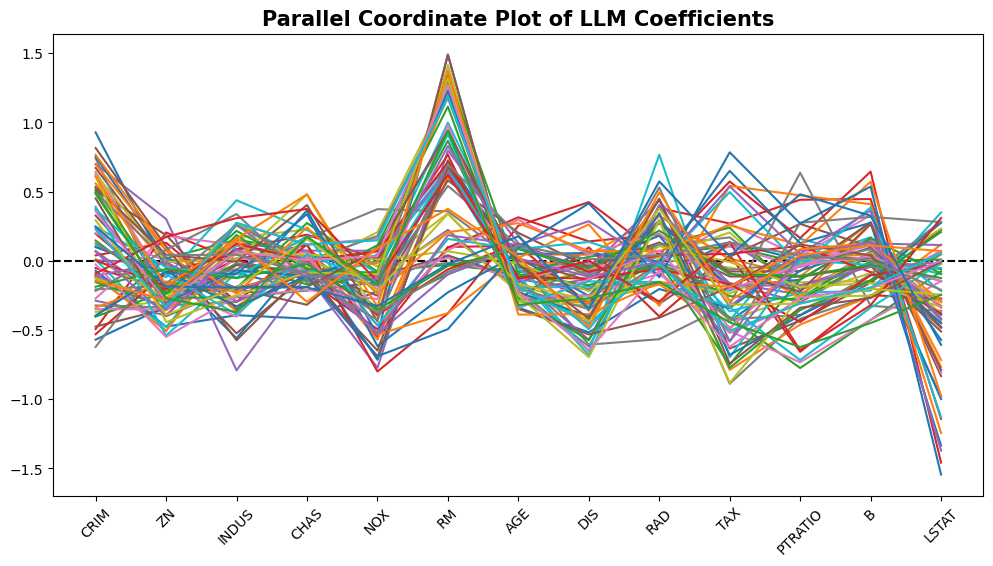

In [9]:
# Parallel coordinate plot of LLMs
fig = clf.pc_plot(figsize=(12, 6), xlabel_rotation=45)

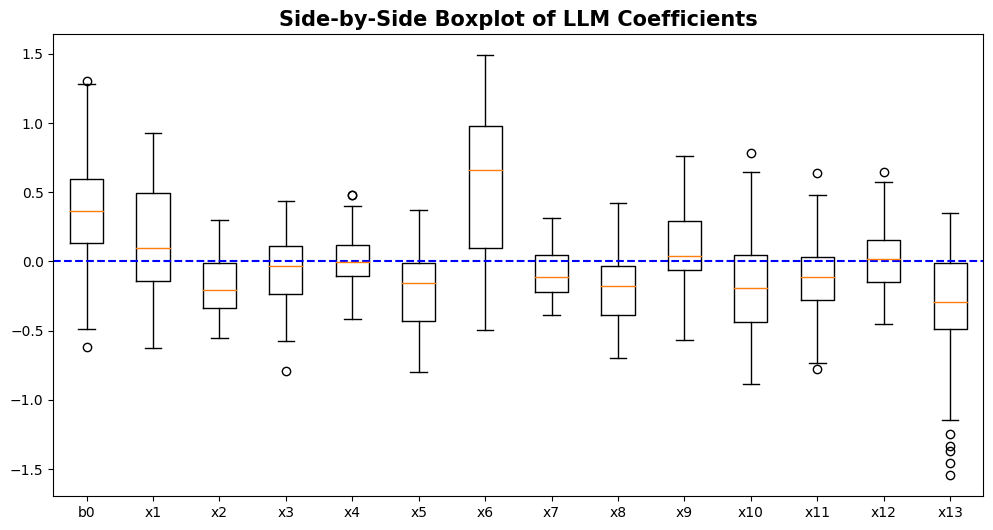

In [10]:
plt.figure(figsize=(12,6))
plt.boxplot(clf.all_bias_weight[np.where(clf.ystd_llms > 0)[0]])
plt.xticks(np.arange(clf.n_features + 1)+1, ["b0"] + ["x" + str(i + 1) for i in range(clf.n_features)])
plt.title("Side-by-Side Boxplot of LLM Coefficients", fontsize=15, fontweight="bold")
plt.axhline(0, linestyle="--", color="blue")
plt.show()

In [11]:
# Identification of region boundary （list of inequalities)
# clf.get_local_boundaries(clf.conflist[0])

# Interpretation and Diagnostics

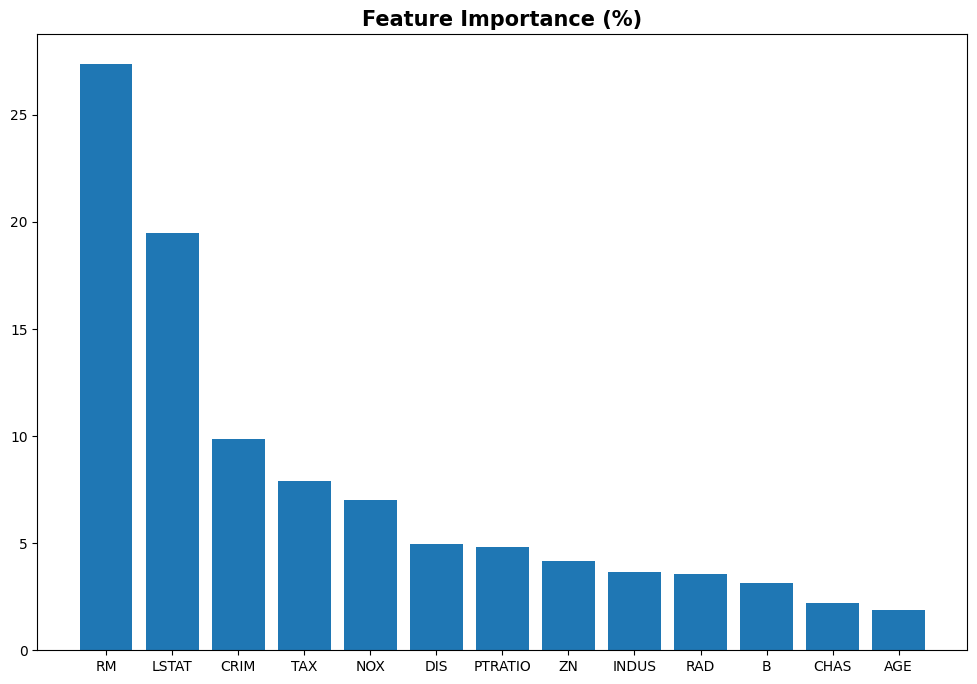

In [12]:
# Feature importance plot
fig = clf.feature_importance_plot(figsize=(12, 8))

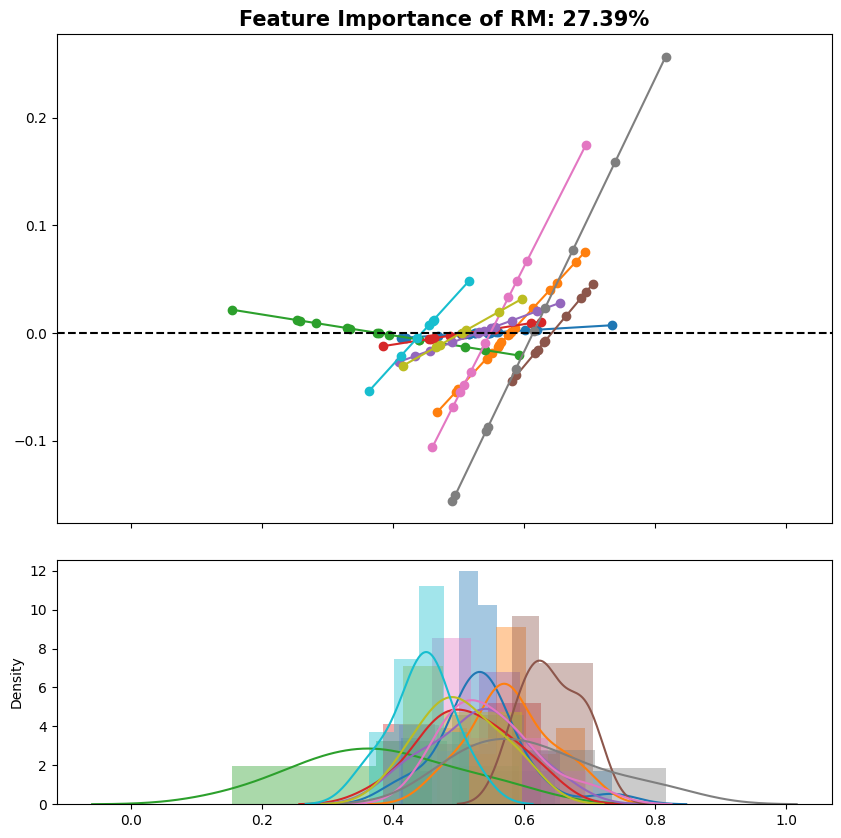

In [13]:
# Local linear profile plot
fig = clf.profile_plot(feature_id=6, figsize=(10, 10))

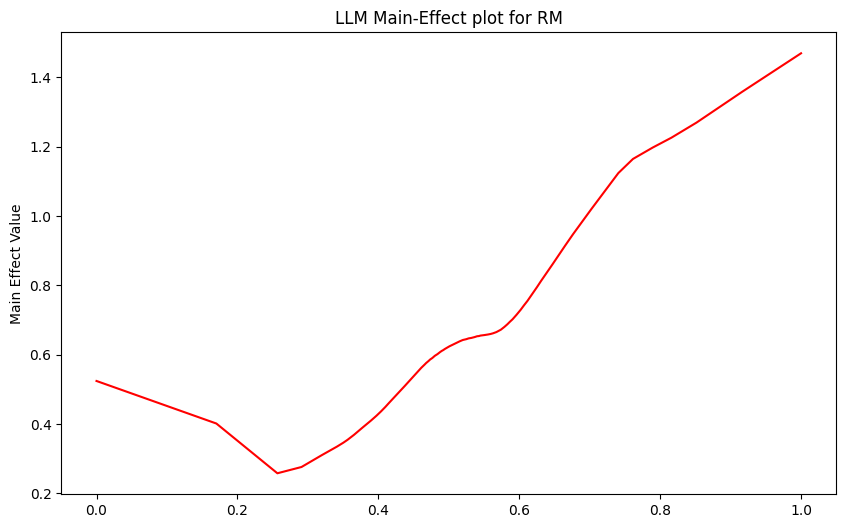

In [14]:
fig = clf.partial_plot(feature_id=6, figsize=(10, 6))

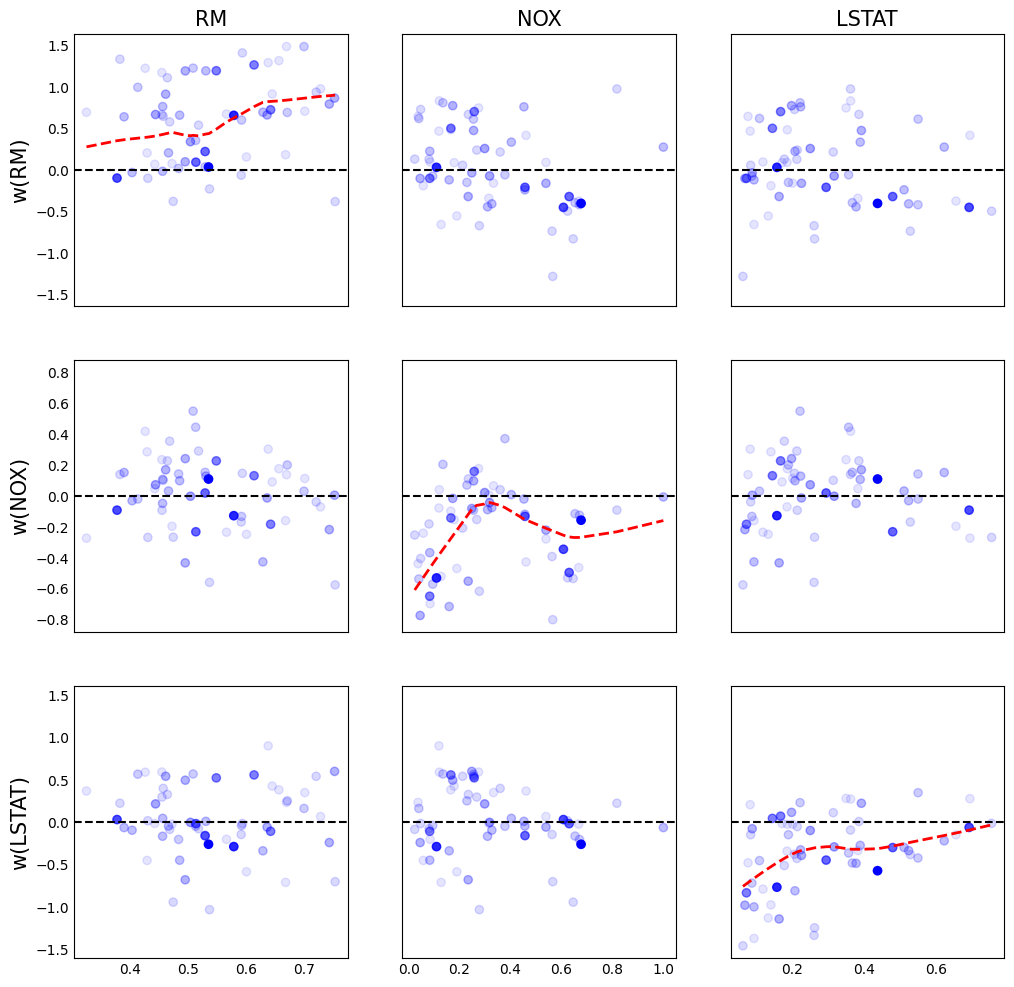

In [15]:
# Pairwise-interaction plot 
# for checking nonlinearlity (diagonal) and interactions (off-diagonal)
fig = clf.pair_plot([6, 5, 13], nllms=60, offdiagsmooth=False)

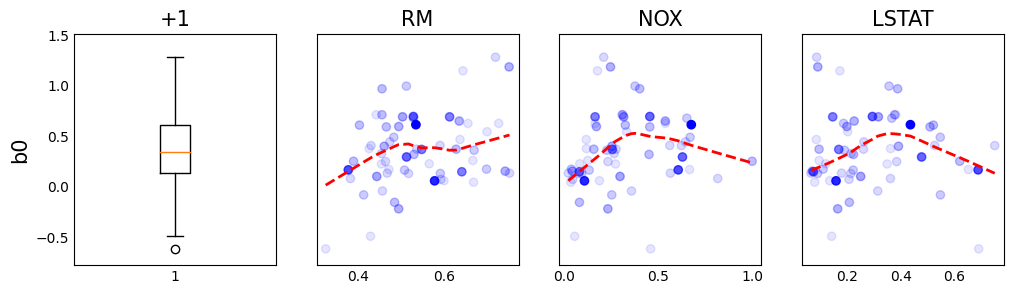

In [16]:
# Intercept plot 
fig = clf.intercept_plot(feature_idx=[6, 5, 13], nllms=60, figsize=(12, 3))

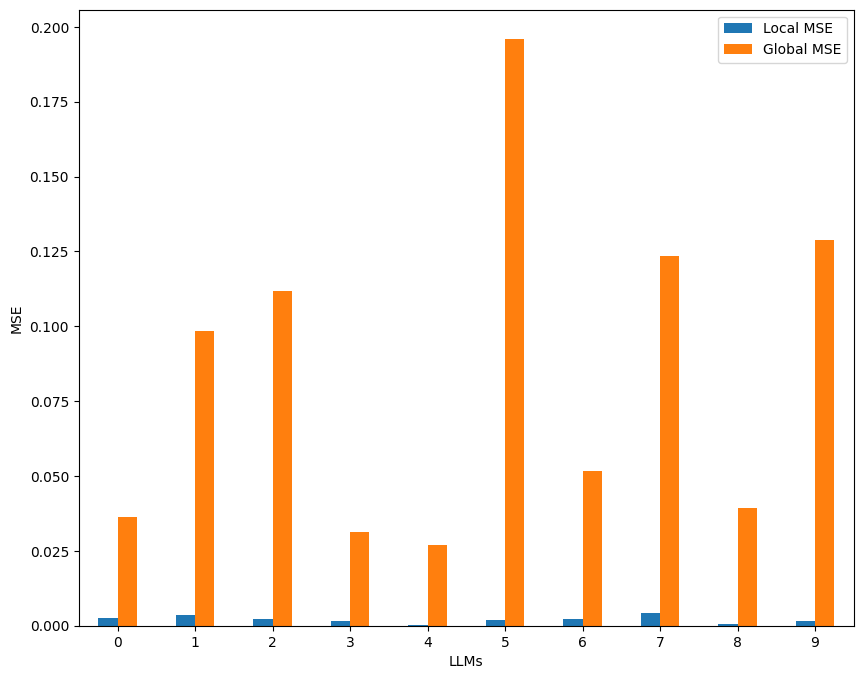

In [17]:
# Local vs. Global perofrmance diagnostics 
fig = clf.diagperf_bar(nllms=10, figsize=(10, 8))

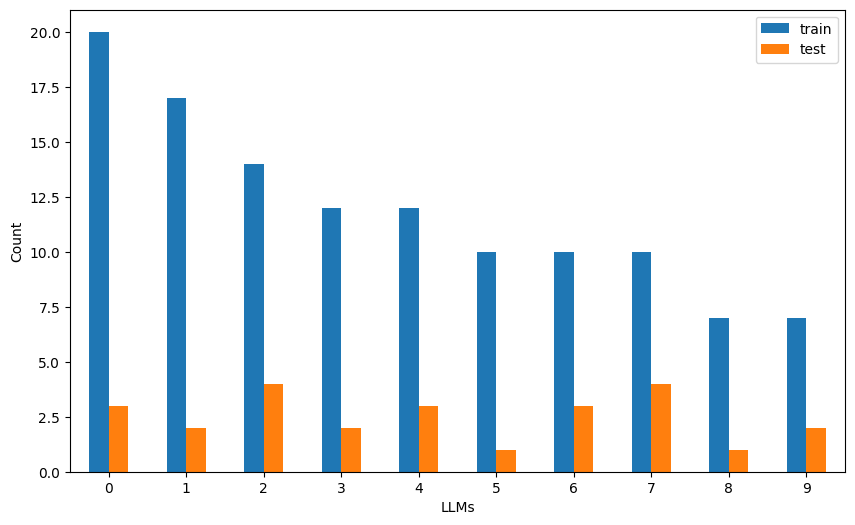

,Count,Response Mean,Response Std,Local MSE,Global MSE
0,3.0,0.283704,0.104618,0.009080,0.048181
1,2.0,0.515556,0.153992,0.003941,0.090390
2,4.0,0.096111,0.080111,0.002094,0.098955
3,2.0,0.158889,0.061283,0.002824,0.043490
4,3.0,0.219259,0.059476,0.015653,0.024401
5,1.0,0.535556,NaN,0.011531,0.190857
6,3.0,0.445185,0.062315,0.000190,0.069831
7,4.0,0.511667,0.176462,0.003741,0.144932
8,1.0,0.342222,NaN,0.000527,0.038489
9,2.0,0.301111,0.076996,0.001559,0.114673


In [18]:
# Exposure of top regions to training and test datasets 
restable, fig = clf.evaluate(test_x, test_y, nllms=10)
restable

# Simplification

In [19]:
## Run the merging algorithm
datanum = train_x.shape[0]
indices = np.arange(datanum)
idx1, idx2 = train_test_split(indices, test_size=0.2, random_state=random_state)
val_fold = np.ones((len(indices)))
val_fold[idx1] = -1

grid = GridSearchCV(MergerRegressor(unwrapper=None, 
                                     weights=mlp.coefs_, 
                                     biases=mlp.intercepts_,
                                     min_samples=30,
                                     feature_names=data.feature_names.tolist(),
                                     n_neighbors=int(np.round(clf.nllms * 0.01)),
                                     refit_model=LassoCV()),
                                     param_grid={"n_clusters": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]},
                                     scoring={"mse": make_scorer(mean_squared_error, greater_is_better=False)},
                                     cv=PredefinedSplit(val_fold), refit="mse", n_jobs=10, error_score=np.nan)
grid.fit(train_x, train_y)
clf_merge = grid.best_estimator_
clf_merge.summary()

,Count,Response Mean,Response Std,Local MSE,Global MSE
0,88.0,0.513990,0.170017,0.003811,0.018443
1,81.0,0.516214,0.205095,0.004435,0.015651
2,68.0,0.295654,0.071393,0.001086,0.023485
3,64.0,0.409618,0.180831,0.004667,0.073450
4,56.0,0.316468,0.195065,0.007480,0.021852
5,47.0,0.149551,0.083397,0.002200,0.051552


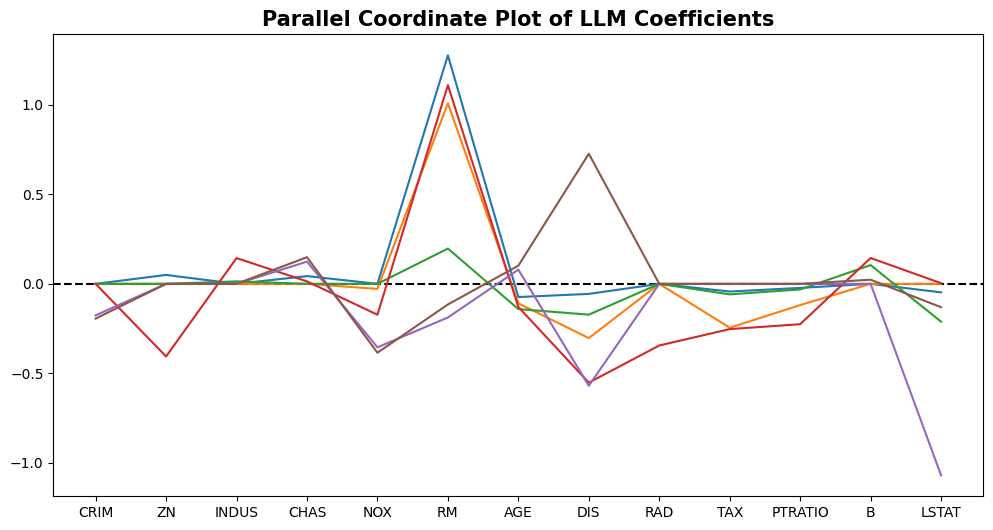

In [20]:
# Parallel coordinate plot of merged LLMs
fig = clf_merge.pc_plot(figsize=(12, 6))

Count            88.000000
Response Mean     0.513990
Response Std      0.170017
Local MSE         0.003811
Global MSE        0.018443
Name: 0, dtype: float64


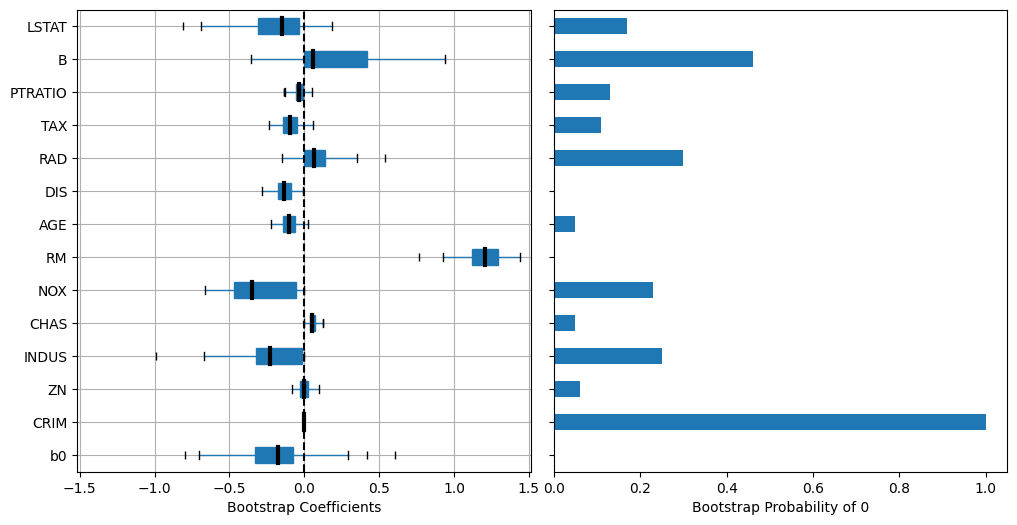

In [21]:
fig = clf_merge.local_inference_bootstrap(0, figsize=(12, 6))

# Performance Comparision: ReLU-Net, Pruner, Merger, Merger + Flatterner 

In [22]:
# Perform simple pruning of the original ReLU net
clf_prune = PrunerRegressor(unwrapper=clf, topk=int(np.sum(clf.count_llms > 1)))
clf_prune.fit(train_x, train_y)

In [23]:
# Perform flattening on the merged net
clf_flatten = clf_merge.flatten(refit_model=LinearRegression())
clf_flatten.fit(train_x, train_y)

In [24]:
# Compare the performance 
train_stat = pd.DataFrame(np.hstack([mean_squared_error(train_y, mlp.predict(train_x)),
           mean_squared_error(train_y, clf_prune.predict(train_x)),
           mean_squared_error(train_y, clf_merge.predict(train_x)),
           mean_squared_error(train_y, clf_flatten.predict(train_x))]).ravel(),
           index=["ReLU-Net", "Prune", "Merge", "Flatten"], columns=["train"]).T
test_stat = pd.DataFrame(np.hstack([mean_squared_error(test_y, mlp.predict(test_x)), 
           mean_squared_error(test_y, clf_prune.predict(test_x)),
           mean_squared_error(test_y, clf_merge.predict(test_x)),
           mean_squared_error(test_y, clf_flatten.predict(test_x))]).ravel(),
           index=["ReLU-Net", "Prune", "Merge", "Flatten"], columns=["test"]).T
pd.concat([train_stat, test_stat]).round(4)

,ReLU-Net,Prune,Merge,Flatten
train,0.0022,0.1952,0.0039,0.0044
test,0.0094,0.1866,0.0092,0.0106
